## Load Dataset

In [ ]:
# ===============================================
# EDA Section: Understanding the Raw Data
# ===============================================

# Import essential libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from ucimlrepo import fetch_ucirepo

# Step 1: Fetch the SUPPORT2 dataset using ucimlrepo
# Rationale: This dataset includes patient records that will be analyzed.
data = fetch_ucirepo(id=880)


### Explatory Data Analysis

In [29]:
# Step 2: Extract features (X) and targets (y)
# Rationale: Separate the main features from the target variables for easier analysis.
X = data.data.features
y = data.data.targets

# Step 3: Create a pandas DataFrame from the features
# Rationale: Provides a structured and consistent format for data exploration.
df = pd.DataFrame(X, columns=data.feature_names)


In [30]:
# Step 4: Display dataset shape and data types
# Rationale: Helps understand the size of the dataset and the types of each feature.
print("Dataset Shape:", df.shape)
print("Data Types:")
print(df.dtypes)

# Step 5: Summary statistics for numerical columns
# Rationale: Provides insights into the distribution and potential outliers.
print("Summary Statistics:")
print(df.describe())

Dataset Shape: (9105, 42)
Data Types:
age         float64
sex          object
dzgroup      object
dzclass      object
num.co        int64
edu         float64
income       object
scoma       float64
charges     float64
totcst      float64
totmcst     float64
avtisst     float64
race         object
sps         float64
aps         float64
surv2m      float64
surv6m      float64
hday          int64
diabetes      int64
dementia      int64
ca           object
prg2m       float64
prg6m       float64
dnr          object
dnrday      float64
meanbp      float64
wblc        float64
hrt         float64
resp        float64
temp        float64
pafi        float64
alb         float64
bili        float64
crea        float64
sod         float64
ph          float64
glucose     float64
bun         float64
urine       float64
adlp        float64
adls        float64
adlsc       float64
dtype: object
Summary Statistics:
               age       num.co          edu        scoma       charges  \
count  9105.0

In [31]:
# Step 6: Check for missing values in the dataset
# Rationale: Identifies columns with missing values that may require imputation later.
print("Missing Values per Column:")
print(df.isnull().sum())

# Step 7: Examine the distribution of target variables
# Rationale: Helps understand the balance of target classes which is important for modeling later.
print("Target Variable Distribution:")
print(y.value_counts())

Missing Values per Column:
age            0
sex            0
dzgroup        0
dzclass        0
num.co         0
edu         1634
income      2982
scoma          1
charges      172
totcst       888
totmcst     3475
avtisst       82
race          42
sps            1
aps            1
surv2m         1
surv6m         1
hday           0
diabetes       0
dementia       0
ca             0
prg2m       1649
prg6m       1633
dnr           30
dnrday        30
meanbp         1
wblc         212
hrt            1
resp           1
temp           1
pafi        2325
alb         3372
bili        2601
crea          67
sod            1
ph          2284
glucose     4500
bun         4352
urine       4862
adlp        5641
adls        2867
adlsc          0
dtype: int64
Target Variable Distribution:
death  hospdead  sfdm2              
1      1         <2 mo. follow-up       2261
0      0         no(M2 and SIP pres)    1673
1      0         no(M2 and SIP pres)    1385
                 <2 mo. follow-up        862

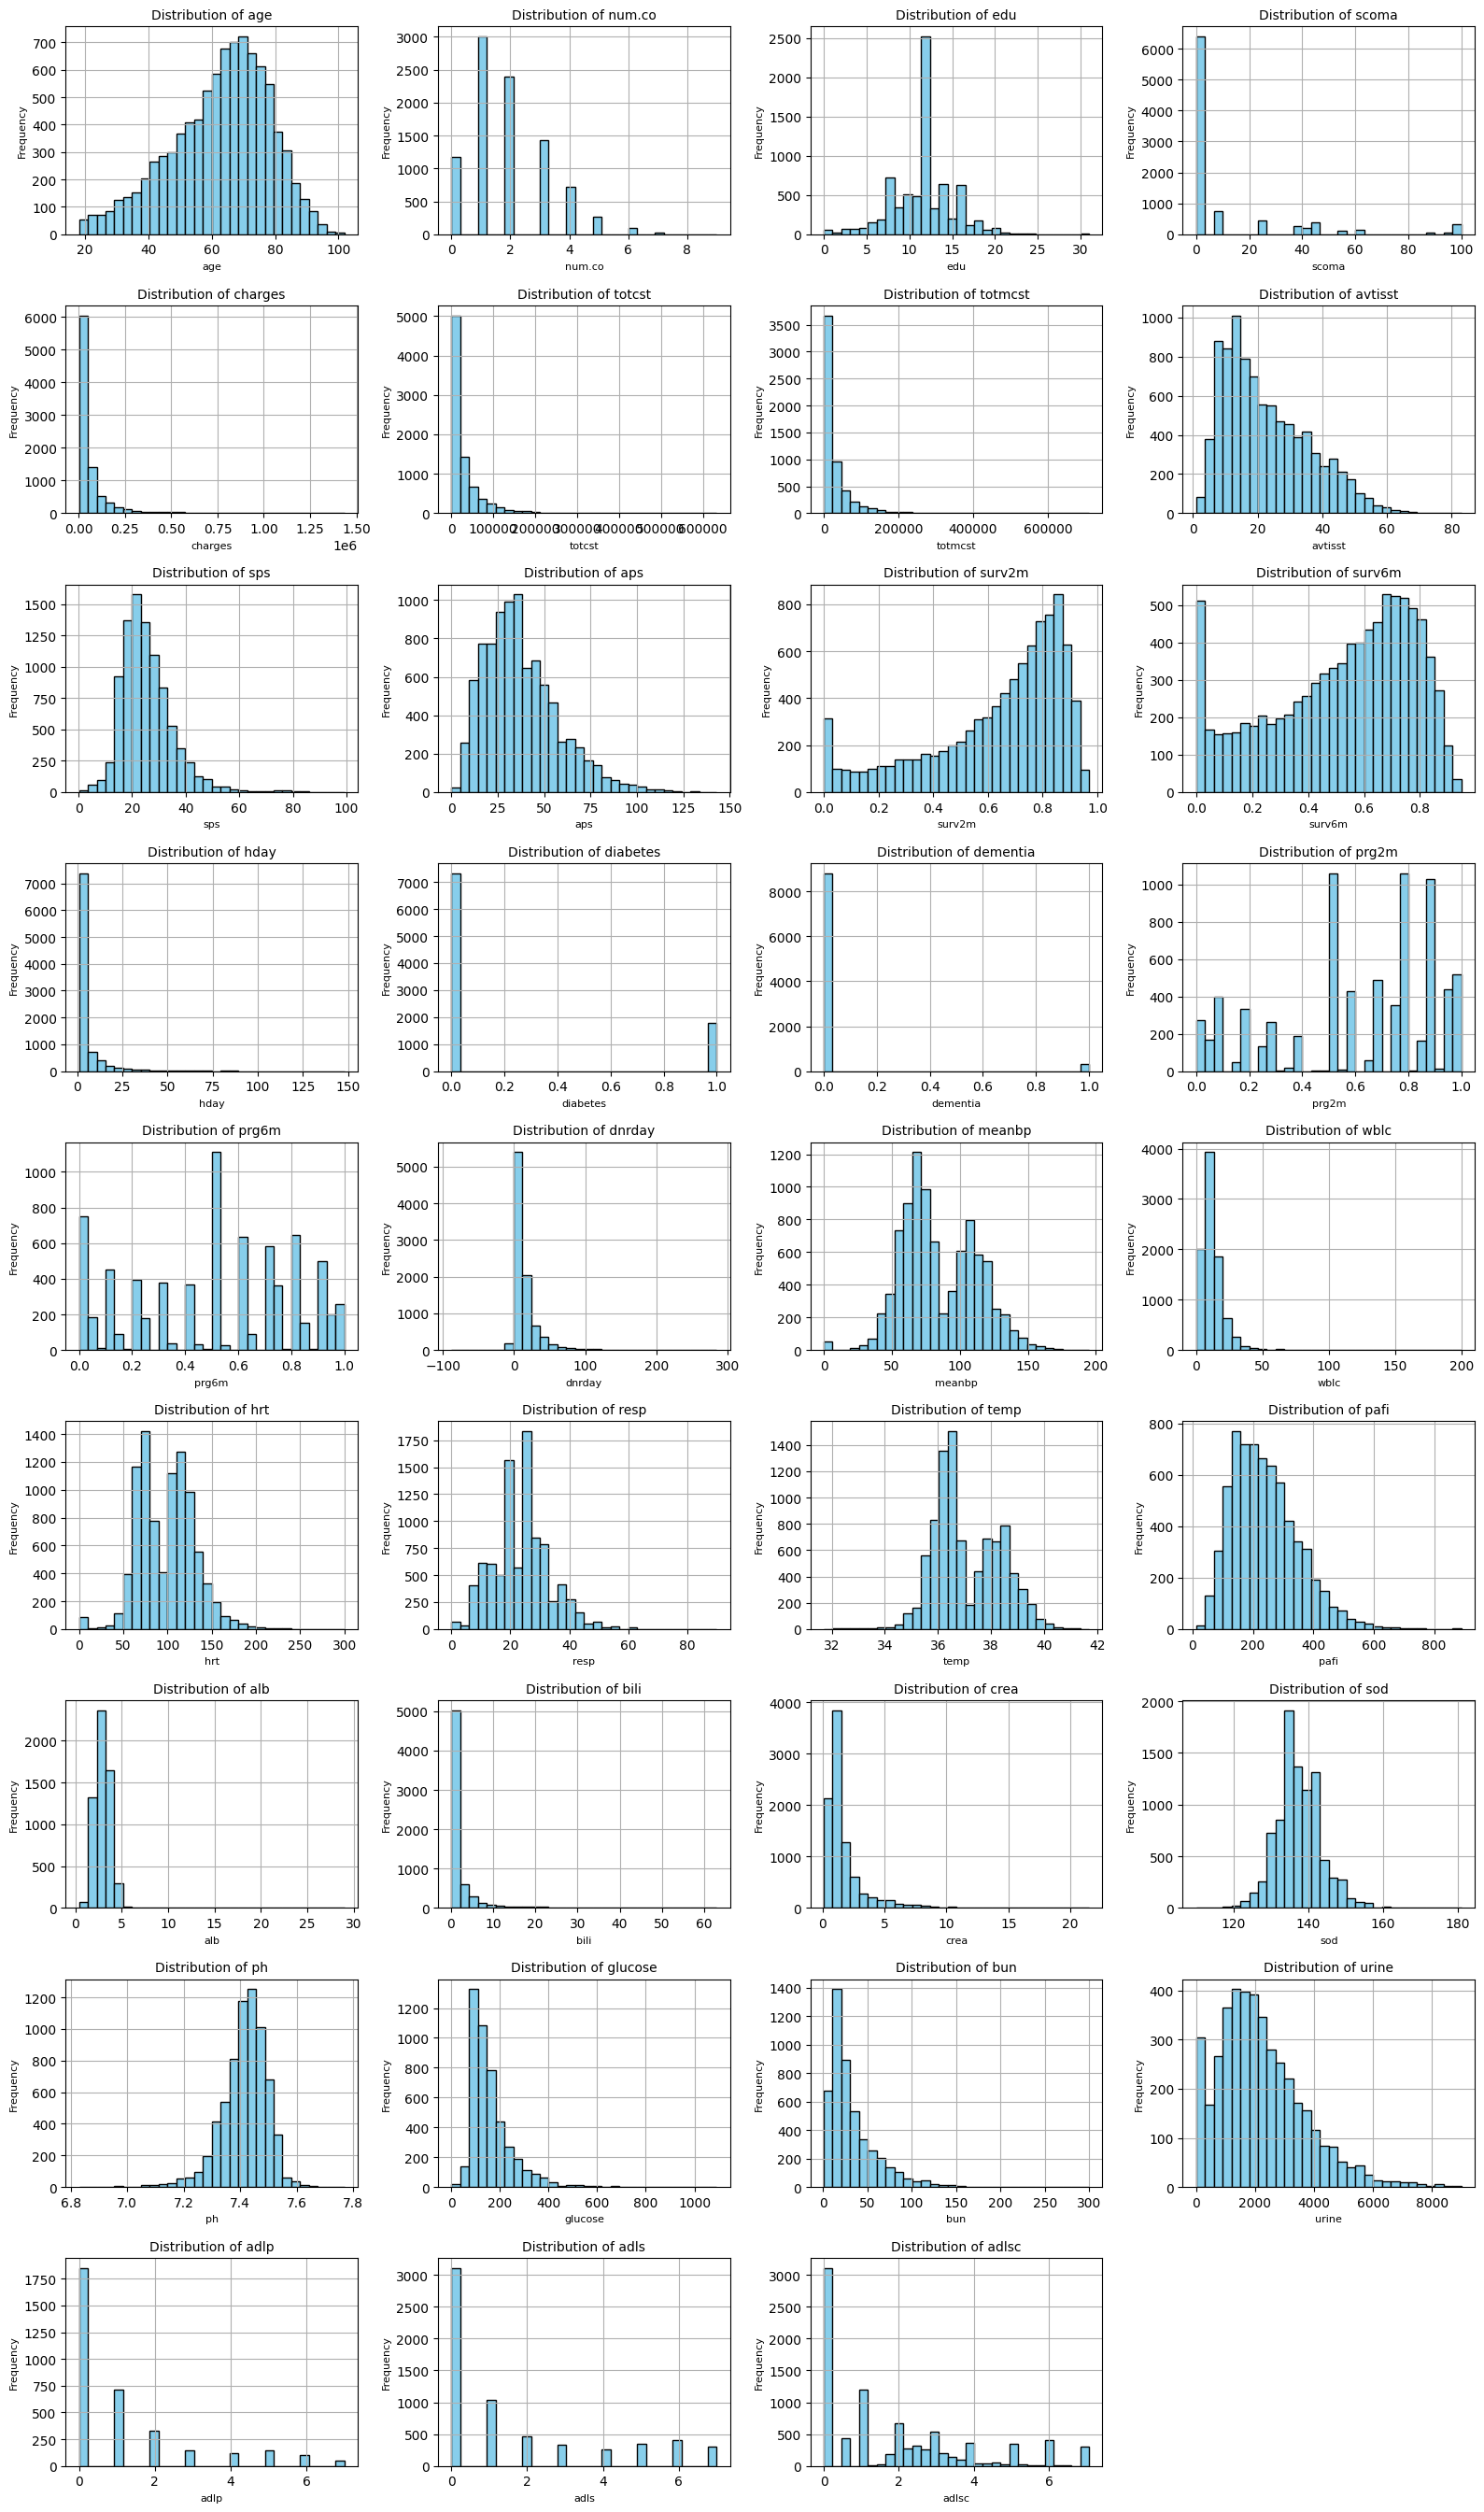

In [32]:
# Step 8: Plot histograms of numerical columns
# Rationale: Visualize the distribution of each numeric feature to detect skewness, outliers, or unusual distributions.
num_cols = len(df.select_dtypes(include='number').columns)
cols = 4
rows = math.ceil(num_cols / cols)

fig = plt.figure(figsize=(cols * 4, rows * 3))
for i, column in enumerate(df.select_dtypes(include='number').columns, 1):
    ax = fig.add_subplot(rows, cols, i)
    df[column].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}', fontsize=10)
    ax.set_xlabel(column, fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
plt.tight_layout()
plt.show()


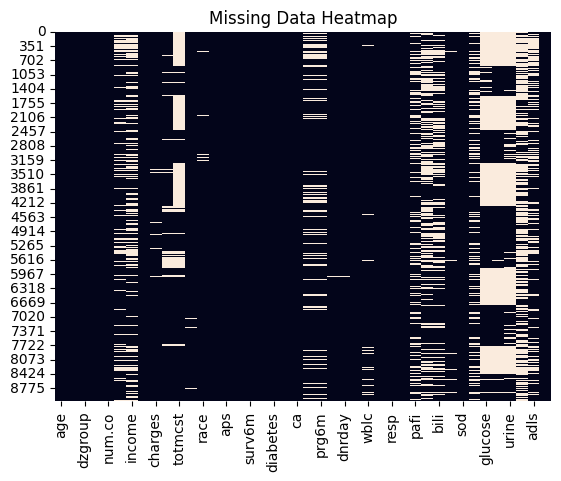

In [33]:
# Step 9: Plot a heatmap of missing data
# Rationale: Visual overview of missing data helps identify patterns or clusters of missingness.
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

In [34]:
# Step 10: Identify categorical columns
# Rationale: Prepares for encoding later, but also useful to understand the data structure.
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns Identified:", cat_cols)
for col in cat_cols:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")


Categorical Columns Identified: ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr']
sex: 2 unique values
dzgroup: 8 unique values
dzclass: 4 unique values
income: 4 unique values
race: 5 unique values
ca: 3 unique values
dnr: 3 unique values


### Pre-processing Section

In [35]:
# ===============================================
# Preprocessing Section: Data Preparation for Modeling
# ===============================================

# Import additional libraries for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [36]:
# Step 1: Perform One-Hot Encoding on categorical variables
# Rationale: Converts categorical variables into numeric format suitable for machine learning models.
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Step 2: Convert boolean columns to integer (if any)
# Rationale: Ensures all columns are numeric for downstream processes like scaling and modeling.
bools_col = df_encoded.select_dtypes(include='bool').columns
df_encoded[bools_col] = df_encoded[bools_col].astype(int)

# Step 3: Drop columns with more than 80% missing values
# Rationale: Columns with too much missing data may be unreliable or introduce noise.
missing_threshold = 0.8
df_encoded_dropNA = df_encoded.loc[:, df_encoded.isnull().mean() < missing_threshold]

# Step 4: Select only numeric columns
# Rationale: Ensures all features are numeric before scaling and imputation.
numeric_cols = df_encoded_dropNA.select_dtypes(include='number').columns
df_cleaned = df_encoded_dropNA[numeric_cols]

# Step 5: Apply Standard Scaling to numeric columns
# Rationale: Standardizes the features by removing the mean and scaling to unit variance.
# This is especially important before iterative imputation and for certain ML algorithms.
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned),
    columns=numeric_cols
)

# Step 6: Impute missing values using Iterative Imputer
# Rationale: Uses regression-based iterative modeling to fill in missing values, preserving relationships between features.
imputer = IterativeImputer(random_state=42)
df_clean = pd.DataFrame(
    imputer.fit_transform(df_numeric_scaled),
    columns=numeric_cols
)

# Step 7: Add target variables back to the cleaned dataset
# Rationale: Prepares the dataset for supervised learning by reintroducing the target columns.
df_clean['death'] = y['death']
df_clean['hospdead'] = y['hospdead']


/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


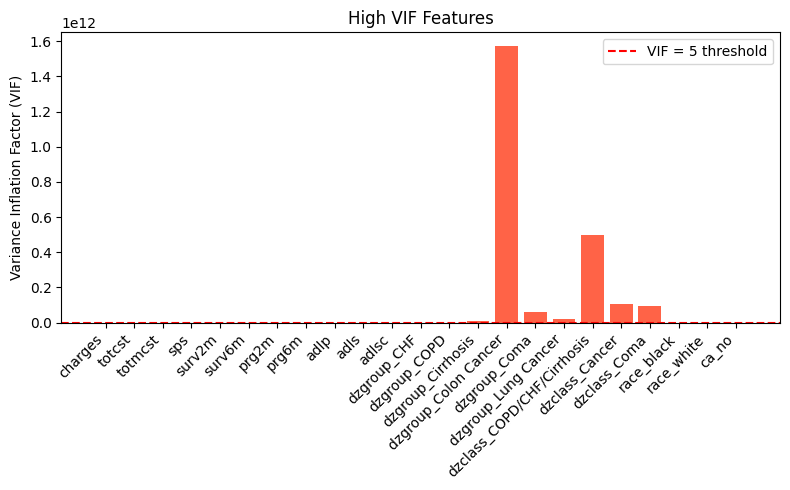

In [37]:
# Step 8: Add a constant column for multicollinearity analysis
# Rationale: The constant is required for Variance Inflation Factor (VIF) calculations.
df_clean_const = add_constant(df_clean)

# Step 9: Calculate VIF for each feature
# Rationale: VIF identifies multicollinearity which can impact model stability and interpretation.
vif_df = pd.DataFrame()
vif_df["feature"] = df_clean_const.columns
vif_df["VIF"] = [variance_inflation_factor(df_clean_const.values, i)
                 for i in range(df_clean_const.shape[1])]


# Step 10: Visualize features with high VIF values
# Rationale: Helps identify features that may require removal or further analysis due to multicollinearity.
threshold = 5
high_vif_df = vif_df[(vif_df['VIF'] > threshold) & (vif_df['feature'] != 'const')]
plt.figure(figsize=(8, 5))
plt.bar(high_vif_df['feature'], high_vif_df['VIF'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'VIF = {threshold} threshold')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.title('High VIF Features')
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# Step 11: Save the cleaned and processed dataset
# Rationale: Saves the preprocessed dataset in a format that can be easily loaded for modeling.
df_clean.to_parquet('../../data/cleaned_output.parquet')
df_clean.to_csv('../../data/cleaned_output.csv')